In [1]:
### Imports

from sklearn.datasets import fetch_lfw_people
from matplotlib import pyplot as plt
from matplotlib.pyplot import imread
import numpy as np
import seaborn as sns
import scipy

import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras import metrics # https://keras.io/metrics/ - ver a parte de custom metrics
from keras.callbacks import History 
from keras.utils.vis_utils import plot_model

import tensorflow as tf

### Funções minhas

# Adicionando ruído às imagens
def add_noise(sigma, bw_img):
    """Adiciona ruído a uma imagem em escala de cinza com valores entre 0 e 1"""
    sh = bw_img.shape
    noise = np.random.normal(0, sigma, sh)
    newgray = bw_img + noise
    #np.clip(newgray, 0, 1) # quando faço isso ela deixa de ser normal!!!
    # vou parar de clipar.
    return newgray

def plot_original_reconstructed(pred, numero):
    figures, axes = plt.subplots(1, 3)
    axes[0].imshow(faces[numero].reshape(60, 44), cmap = 'gray')
    axes[0].set_title('Original image')
    axes[1].imshow(newfaces[numero].reshape(60, 44), cmap = 'gray')
    axes[1].set_title('Input (noisy image)')
    axes[2].imshow(pred[numero].reshape(60, 44), cmap = 'gray')
    axes[2].set_title('Reconstructed')

def plot_compare(idx, original, noisy, predicted):
    figures, axes = plt.subplots(1, 3)
    axes[0].imshow(original[idx].reshape(60, 44), cmap = 'gray')
    axes[0].set_title('Original image')
    axes[1].imshow(noisy[idx].reshape(60, 44), cmap = 'gray')
    axes[1].set_title('Input (noisy image)')
    axes[2].imshow(predicted[idx].reshape(60, 44), cmap = 'gray')
    axes[2].set_title('Reconstructed')

## Funcao custo customizada: SSIM

def ssim_loss(y_true, y_pred):
  return -tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

Using TensorFlow backend.


## MSE cost function, 200 iter

In [2]:
from keras.models import load_model
import pickle

In [3]:
modelo = load_model('200iter_MSE')

In [4]:
historias = pickle.load( open( "save_historias_200iter_mse", "rb" ) )

Metrics inside the history object

'loss'
'mean_squared_error' (which is the same as loss in this scenario)
'mean_absolute_error'
'binary_crossentropy'
'accuracy' 

'val_loss'
'val_mean_squared_error' (which is the same as loss in this scenario)
'val_mean_absolute_error'
'val_binary_crossentropy'
'val_accuracy' 

In [5]:
import seaborn as sns

Text(0.5, 1.0, 'cost fun = MSE, 200 iter')

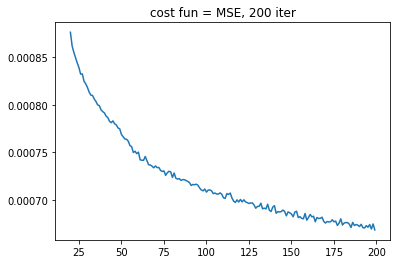

In [6]:
start = 20
finish = 200

y = historias.history['loss'][start:finish]
x = range(start, finish)
sns.lineplot(x, y).set_title('cost fun = MSE, 200 iter')

# How does this network perform when given an image that has a different nature than the ones in its training set?

In [8]:
from matplotlib.pyplot import imread
apple = imread("apple.jpg")
flower = imread("flower.png")
blackhole = imread("blackhole.jpg")

Turning the images into black and white

In [9]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [10]:
apple_bw = rgb2gray(apple)
flower_bw = rgb2gray(flower)
blackhole_bw = rgb2gray(blackhole)

Making sure the pixel values are between 0 and 1

In [11]:
apple_bw = apple_bw/np.amax(apple_bw)
flower_bw = flower_bw/np.amax(flower_bw)
blackhole_bw = blackhole_bw/np.amax(blackhole_bw)

Text(0.5, 1.0, 'Blackhole (original, b&w)')

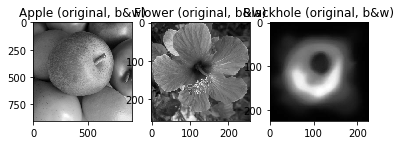

In [12]:
figures, axes = plt.subplots(1, 3)
axes[0].imshow(apple_bw, cmap = 'gray')
axes[0].set_title('Apple (original, b&w)')
axes[1].imshow(flower_bw, cmap = 'gray')
axes[1].set_title('Flower (original, b&w)')
axes[2].imshow(blackhole_bw, cmap = 'gray')
axes[2].set_title('Blackhole (original, b&w)')

Checking the shapes

In [14]:
apple_bw.shape 

(900, 900)

In [15]:
flower_bw.shape

(256, 256)

In [16]:
blackhole_bw.shape

(225, 225)

I need to rescale the images so that they fit inside the network's input layer.

In [17]:
from skimage.transform import rescale, resize, downscale_local_mean

In [18]:
apple_bw_resized = resize(apple_bw, (60, 44), anti_aliasing=False)
flower_bw_resized = resize(flower_bw, (60, 44), anti_aliasing=False)
blackhole_bw_resized = resize(blackhole_bw, (60, 44), anti_aliasing=False)

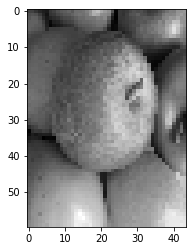

In [19]:
plt.imshow(apple_bw_resized, cmap = 'gray')

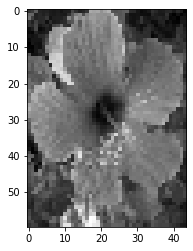

In [20]:
plt.imshow(flower_bw_resized, cmap = 'gray')

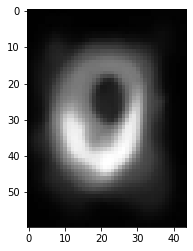

In [21]:
plt.imshow(blackhole_bw_resized, cmap = 'gray')

Text(0.5, 1.0, 'Blackhole (resized, b&w)')

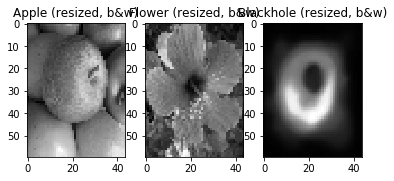

In [22]:
figures, axes = plt.subplots(1, 3)
axes[0].imshow(apple_bw_resized, cmap = 'gray')
axes[0].set_title('Apple (resized, b&w)')
axes[1].imshow(flower_bw_resized, cmap = 'gray')
axes[1].set_title('Flower (resized, b&w)')
axes[2].imshow(blackhole_bw_resized, cmap = 'gray')
axes[2].set_title('Blackhole (resized, b&w)')
#figures.subplots_adjust(wspace=0.005)

In [23]:
# Adding noise to the images
apple_noisy = add_noise(0.05, apple_bw_resized)
flower_noisy = add_noise(0.05, flower_bw_resized)
blackhole_noisy = add_noise(0.05, blackhole_bw_resized)

Text(0.5, 1.0, 'Blackhole (resized, noisy, b&w)')

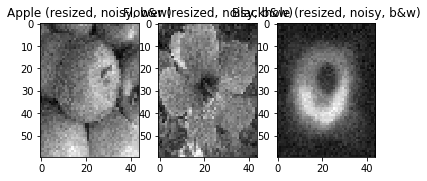

In [24]:
figures, axes = plt.subplots(1, 3)
axes[0].imshow(apple_noisy, cmap = 'gray')
axes[0].set_title('Apple (resized, noisy, b&w)')
axes[1].imshow(flower_noisy, cmap = 'gray')
axes[1].set_title('Flower (resized, noisy, b&w)')
axes[2].imshow(blackhole_noisy, cmap = 'gray')
axes[2].set_title('Blackhole (resized, noisy, b&w)')

In [25]:
# Reshaping the arrays so that they fit inside the network's input layer
apple_noisy = apple_noisy.reshape(-1, 60, 44, 1)
flower_noisy = flower_noisy.reshape(-1, 60, 44, 1)
blackhole_noisy = blackhole_noisy.reshape(-1, 60, 44, 1)

In [26]:
# Predictions
apple_pred = modelo.predict(apple_noisy)
flower_pred = modelo.predict(flower_noisy) 
blackhole_pred = modelo.predict(blackhole_noisy)

Text(0.5, 1.0, 'Reconstructed')

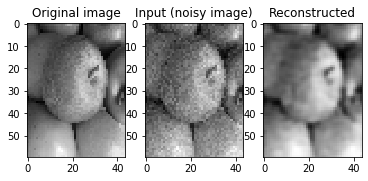

In [27]:
figures, axes = plt.subplots(1, 3)
axes[0].imshow(apple_bw_resized.reshape(60, 44), cmap = 'gray')
axes[0].set_title('Original image')
axes[1].imshow(apple_noisy.reshape(60, 44), cmap = 'gray')
axes[1].set_title('Input (noisy image)')
axes[2].imshow(apple_pred.reshape(60, 44), cmap = 'gray')
axes[2].set_title('Reconstructed')

Text(0.5, 1.0, 'Reconstructed')

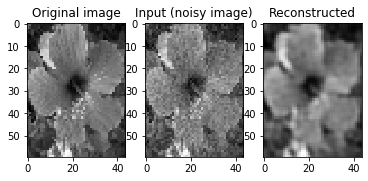

In [28]:
figures, axes = plt.subplots(1, 3)
axes[0].imshow(flower_bw_resized.reshape(60, 44), cmap = 'gray')
axes[0].set_title('Original image')
axes[1].imshow(flower_noisy.reshape(60, 44), cmap = 'gray')
axes[1].set_title('Input (noisy image)')
axes[2].imshow(flower_pred.reshape(60, 44), cmap = 'gray')
axes[2].set_title('Reconstructed')

Text(0.5, 1.0, 'Reconstructed')

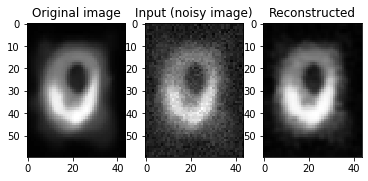

In [29]:
figures, axes = plt.subplots(1, 3)
axes[0].imshow(blackhole_bw_resized.reshape(60, 44), cmap = 'gray')
axes[0].set_title('Original image')
axes[1].imshow(blackhole_noisy.reshape(60, 44), cmap = 'gray')
axes[1].set_title('Input (noisy image)')
axes[2].imshow(blackhole_pred.reshape(60, 44), cmap = 'gray')
axes[2].set_title('Reconstructed')

## Prediction on a fully gray image

In [89]:
gray = np.full((60, 44), 0.5)

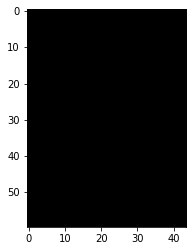

In [90]:
plt.imshow(gray, cmap = 'gray')

In [92]:
gray_noisy = add_noise(0.05, gray)

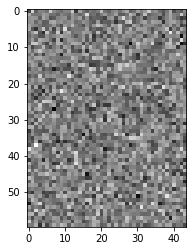

In [93]:
plt.imshow(gray_noisy, cmap = 'gray') # why is the noise so strong?

In [94]:
gray_noisy = gray_noisy.reshape(-1, 60, 44, 1)

In [95]:
gray_pred = modelo.predict(gray_noisy)

Text(0.5, 1.0, 'Reconstructed')

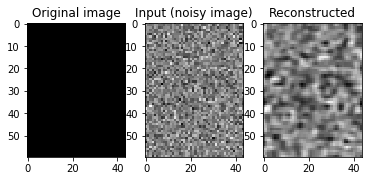

In [96]:
figures, axes = plt.subplots(1, 3)
axes[0].imshow(gray.reshape(60, 44), cmap = 'gray')
axes[0].set_title('Original image')
axes[1].imshow(gray_noisy.reshape(60, 44), cmap = 'gray')
axes[1].set_title('Input (noisy image)')
axes[2].imshow(gray_pred.reshape(60, 44), cmap = 'gray')
axes[2].set_title('Reconstructed')

## Trying to load the SSIM network (200 iter) - failed!!

In [ ]:
def ssim_loss(y_true, y_pred):
  return -tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [ ]:
modelo = load_model('200iter_SSIM', compile=False)

In [ ]:
modelo.compile(optimizer = 'adam', loss = ssim_loss)

In [ ]:
historias = pickle.load( open( "save_historias_200iter_ssim", "rb" ))

It is unsafe to pickle a Keras model. Rather than doing this, consider using model.save(path, format='tf'),
which will use the SavedModel format and which will also include the custom objects. - https://github.com/tensorflow/tensorflow/issues/32818